In [1]:
#import sys
#sys.path.append('C:\\Users\\mabdalla\\OneDrive - ec-lyon.fr\\Documents\\Python Scripts\\packages')
import torch
import numpy as np
import pandas as pd
import photontorch as pt
from photontorch.environment import current_environment
import matplotlib.pyplot as plt
from scipy.signal import butter#, lfilter
from torch_lfilter import lfilter

In [2]:
class wg(pt.Network):
    def __init__(self):
        super(wg,self).__init__()
        self.src = pt.Source()
        self.wg = pt.Waveguide()
        self.det = pt.Detector()
        self.link("src:0", "0:wg:1", "0:det")

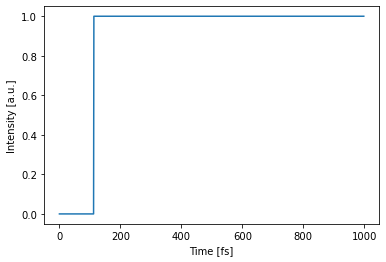

In [3]:
wg_Circuit = wg()

time_env = pt.Environment(dt=1e-15, t1=1e-12, wl=1.55e-6)

freq_env = pt.Environment(
    wl=1e-6*np.linspace(1.54, 1.56, 1000),
    freqdomain=True
)
sin_source = torch.tensor(np.sin(time_env.time*4e10), dtype=torch.float32, names=["t"]) # lower dimensional source should have named dimensions.

with time_env:
    detected = wg_Circuit(source=1)
    wg_Circuit.plot(detected)
    plt.show()   

In [4]:
class PD(pt.Component):
    """
    The PD is a photodector which acts instantaneously on the input optical power,
    converting it to current according to the input wavelength-independendt responsivity.
    Note: At R=1, this is the equivalent component of the built-in detector term.
    An optional Resistance can be added to output a voltage instead, to model a simple TIA operating at DC.

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        R = 1, #Responsivity
        Z = 1, #TIA Impedence (Resistance)
        name = None,  
        ):
        
        super(PD,self).__init__(name=name)    
        self.R = float(R)
        self.Z = float(Z)
        
    def action(self, t, x_in, x_out):
        
        a_in, _ = x_in

        x_out[0] = a_in  #Nothing happens to input node
        
        
        x_out[1,0] = self.R*self.Z*(a_in[0]**2+a_in[1]**2)  #PD Equation
        
        x_out[1,1] = 0  #lose the phase information
        
        #print(x_out[1,0])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S
    


#### The source value is the E-field amplitude. The detected Power is the square of the source value.

In [5]:
class wg_det(pt.Network):
    def __init__(self):
        super(wg_det,self).__init__()
        self.src = pt.Source()
        self.wg = pt.Waveguide()
        self.pd = PD()
        self.det = pt.Detector()
        self.link("src:0", "0:wg:1",'0:pd:1', "0:det")

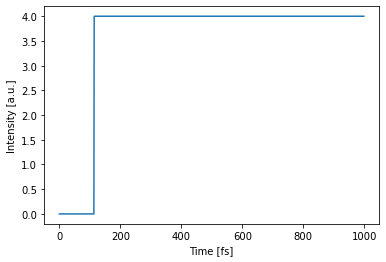

In [6]:
det_Circuit = wg_det()

time_env = pt.Environment(dt=1e-15, t1=1e-12, wl=1.55e-6)

freq_env = pt.Environment(
    wl=1e-6*np.linspace(1.54, 1.56, 1000),
    freqdomain=True
)
sin_source = torch.tensor(np.sin(time_env.time*4e10), dtype=torch.float32, names=["t"]) # lower dimensional source should have named dimensions.

with time_env:
    detected = torch.sqrt(det_Circuit(source=2)) #To display the detected power
    #detected = det_Circuit(source=2)
    det_Circuit.plot(detected)
    plt.show()   

#### The detected value is correct: The extra square comes from the photodetector (To display its real value simply apply toch.sqrt for the readout)

In [7]:
class det(pt.Network):
    def __init__(self):
        super(det,self).__init__()
        self.src = pt.Source()
        self.pd = PD()
        self.det = pt.Detector()
        self.link("src:0", '0:pd:1', "0:det")

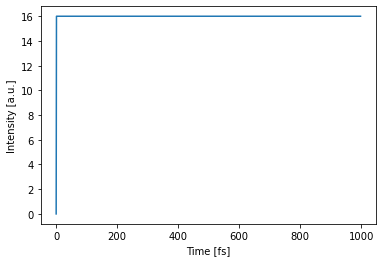

In [8]:
det_Test = det()

time_env = pt.Environment(dt=1e-15, t1=1e-12, wl=1.55e-6)

freq_env = pt.Environment(
    wl=1e-6*np.linspace(1.54, 1.56, 1000),
    freqdomain=True
)
sin_source = torch.tensor(np.sin(time_env.time*4e10), dtype=torch.float32, names=["t"]) # lower dimensional source should have named dimensions.

with time_env:
    detected = det_Test(source=2)
    det_Test.plot(detected)
    plt.show()   

#### This is the behavior of the PD without the delay effect of the waveguide.

In [9]:
class MZI_trial(pt.Component):
    """
    This is a 2 port testing unit of below 3-Port MZI. It has a predefined input voltage to ease the testing.

    Terms: 
  Optical  0 ----- 1  Optical
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        vin = 1.0, #input voltage
        vpi = 3.0, #Voltage to acquire Pi phase shift
        neff = 2.34, #effective index
        ng = 3.40, #group index
        wl0 = 1.55e-6, #wavelength for defined neff
        length = 1.5e-6, #waveguide length (m)
        loss = 0, #The loss would be both Y-jun loss + both waveguide losses
        name = None,  
        ):
        
        super(MZI_trial,self).__init__(name=name)   
        self.vin = float(vin)
        self.vpi=float(vpi)
        self.neff = float(neff)
        self.ng = float(ng)
        self.length = float(length)
        self.loss = float(loss)
        self.wl0 = float(wl0)
        
    def set_delays(self,delays):
        delays[:] = self.ng * self.length/self.env.c
        
    def action(self, t, x_in, x_out):
        
        a_in, _ = x_in     #Port0: input optical amplitude, Port1: input Voltage, Port2: O/p node (no need to store)
        
        
        #print(a_in)  #for debugging
        
        x_out[0] = a_in #Nothing happens to optical input node
        
        #print(a_in)
        
        wls = torch.tensor(self.env.wl, dtype=torch.float64, device=self.device)
        
        #print(x_out[1])
        # neff depends on the wavelength:
        neff = self.neff - (wls - self.wl0) * (self.ng - self.neff) / self.wl0
        
        phase = (2 * np.pi * neff * self.length / wls) #% (2 * np.pi) #Phase due to waveguide propagation
        
        Ei = torch.sqrt(a_in[0]**2+a_in[1]**2) #Input amplitude
                
        mzi_eq_re = 0.5 * Ei * (torch.cos(phase) + np.cos(phase + np.pi * (self.vin / self.vpi)))  #Real
        
        mzi_eq_im = 0.5 * Ei * (torch.sin(phase) + np.sin(phase + np.pi * (self.vin / self.vpi))) #Imaginary
        
        x_out[1,0] = mzi_eq_re  
        x_out[1,1] =  mzi_eq_im
        
        #print(x_out[1])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1  #Actions must be defined for all ports in active devices
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S


In [10]:
class MZI_test(pt.Network):
    def __init__(self):
        super(MZI_test,self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.mzi = MZI_trial(vin=3)
        self.link("src:0", "0:mzi:1", "0:det")
        #self.link("src:0", "1:mzi")

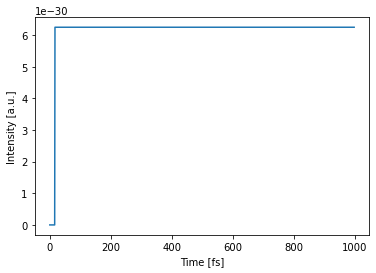

In [11]:
mzi = MZI_test()

time_env = pt.Environment(dt=1e-15, t1=1e-12, wl=1.55e-6)

with time_env:
    detected3 = mzi(source=3)
    mzi.plot(detected3)
    plt.show()

In [12]:
class Pass(pt.Component):
    """
    The pass component is useful in monitoring complex amplitude behavior of the component connected to it.
    It prints the input tensor as is. 

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        name = None,  
        ):
        
        super(Pass,self).__init__(name=name)    
        
    def action(self, t, x_in, x_out):
        
        a_in, _ = x_in
        #print(a_in)
        x_out[0] = a_in  #Nothing happens to input node
        
        x_out[1] = a_in  
                
        print(x_out[1])
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[0.]]])
Buffer containing:
tensor([[[0.]],

        [[

Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tenso

Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tenso

Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tensor([[[0.8208]],

        [[0.5713]]])
Buffer containing:
tenso

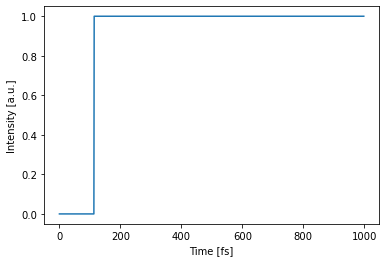

In [13]:
class wg_pass(pt.Network):
    def __init__(self):
        super(wg_pass,self).__init__()
        self.src = pt.Source()
        self.wg = pt.Waveguide()
        self.pas = Pass()
        self.det = pt.Detector()
        self.link("src:0", "0:wg:1",'0:pas:1', "0:det")
        
wg_pass = wg_pass()

with time_env:
    detected = wg_pass(source=1)
    wg_pass.plot(detected)

### We now proceed to create the MZI component with 3 ports:

In [14]:
class MZI(pt.Component):
    """
    This is a 3 port implementation of symmetric MZI-based (equal arm-lengths) Intensity modulator. 
    An input voltage adds a phase to the phase induced by one of the arms.
    Note: This implementation assumes it will be connected to a real source.

    Terms: 
  Optical  0 ----- 2  Optical
               |
               |
               1 
           Electrical
    
    """    
    num_ports = 3
    
    def __init__(
        self,
        vpi = 3.0, #Voltage to acquire Pi phase shift
        neff = 2.34, #effective index
        ng = 3.40, #group index
        wl0 = 1.55e-6, #wavelength for defined neff
        length = 1.5e-6, #waveguide length (m)
        loss = 0, #The loss would be both Y-jun loss + both waveguide losses
        name = None,  
        ):
        
        super(MZI,self).__init__(name=name)    
        self.vpi=float(vpi)
        self.neff = float(neff)
        self.ng = float(ng)
        self.length = float(length)
        self.loss = float(loss)
        self.wl0 = float(wl0)
        
    #def set_delays(self,delays):
        #delays[:] = self.ng * self.length/self.env.c
        
    def action(self, t, x_in, x_out):
        
        a_in, v_in, _ = x_in     #Port0: input optical amplitude, Port1: input Voltage, Port2: O/p node (no need to store)
        
        v = v_in[0]  #The 'real' part of voltage signal 
        #print(a_in)  #for debugging
        
        x_out[0] = a_in  #Nothing happens to optical input node
        
        x_out[1] = v_in #Nothing happens to electrical input port
        
        wls = torch.tensor(self.env.wl, dtype=torch.float64, device=self.device)

        # neff depends on the wavelength:
        neff = self.neff - (wls - self.wl0) * (self.ng - self.neff) / self.wl0
        
        phase = (2 * np.pi * neff * self.length / wls) #% (2 * np.pi) #Phase due to waveguide propagation
        
        Ei = torch.sqrt(a_in[0]**2 + a_in[1]**2) #Input amplitude

        mzi_eq_re = 0.5 * Ei * (torch.cos(phase) + torch.cos(phase + np.pi * (v / self.vpi)))  #Real
        mzi_eq_im = 0.5 * Ei * (torch.sin(phase) + torch.sin(phase + np.pi * (v / self.vpi))) #Imaginary
        
        x_out[2,0] = mzi_eq_re  
        x_out[2,1] = mzi_eq_im
        
        #print(x_out[2])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1  #Actions must be defined for all ports in active devices
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        S[0,:,2,2] = 1.0
        return S

In [15]:
class MZI_3Port_Test(pt.Network):
    def __init__(self):
        super(MZI_3Port_Test,self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.mzi = MZI()
        self.link("src:0", "0:mzi:2", "0:det")
        self.link("src:0", "1:mzi")
        #self.link("src:0", "1:mzi")

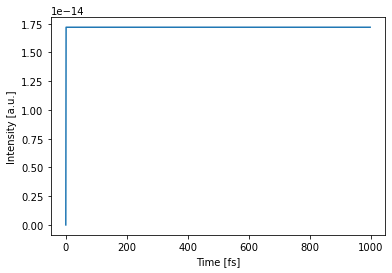

In [16]:
mzi = MZI_3Port_Test()

time_env = pt.Environment(dt=1e-15, t1=1e-12, wl=1.55e-6)

with time_env:
    detected3 = mzi(source=3.0)
    mzi.plot(detected3)
    plt.show()

### In the 2 port equivalent circuit earlier, the value at Vpi was ~ e-30 while here the value is ~ e-14. It can still be considered 0  (The extinction ratio is higher in practical devices). For all other Vin they are identical.

### Now let us build the reservoir: It consists of CW Source, MZI, Waveguide, 1x2 MMI (for readout), PD + TIA connected back to MZI

In [17]:
class reservoir(pt.Network):
    def __init__(self):
        super(reservoir, self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.pd = PD(Z=1)
        self.mmi = pt.Mmi()
        self.wg = pt.Waveguide()
        self.mzi = MZI()
        self.link("src:0", "0:mzi:2", "0:wg:1", "0:mmi:1", "0:pd:1", "1:mzi")
        self.link("mmi:2", "0:det")

print(torch.where(reservoir().free_ports_at)[0])                


Buffer containing:
tensor([], dtype=torch.int64)


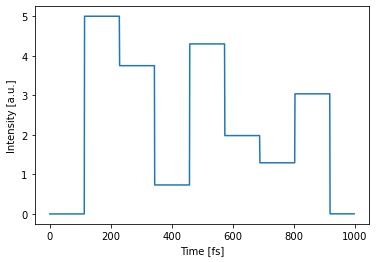

In [23]:
Reservoir = reservoir()

time_env = pt.Environment(dt=1e-15, t1=1e-12, wl=1.55e-6)

with time_env:
    detected = Reservoir(source=np.sqrt(10))  ###Write the desired input Power value here
    Reservoir.plot(detected)
    plt.show() 

### The feedback loop works, The photodetector drives the MZI which in turn modulates the laser intensity. Note the delay in this loop is due to MZI length + Waveguide.

### Moreover, this is compared to Lumerical IC ouput of the same circuit, the values are the same.

In [19]:
text_file = open("NonlinearComponents.txt", "r")
lines = text_file.read().split(',')

In [20]:
import pandas as pd
data = pd.read_csv('NonlinearComponents.txt',sep=',',header=None)
data = pd.DataFrame(data)

data = pd.DataFrame(detected)
data.to_csv('mohab.csv')